

---



## Setting

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Preprocessing

In [0]:
data_dir = '/content/drive/Shared drives/Predictive Competition/recruit-restaurant-visitor-forecasting/'

In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np

## Load files

In [0]:
print("Loading Data ...")

air_reserve = pd.read_csv(data_dir+'air_reserve.csv')
air_store_info = pd.read_csv(data_dir+'air_store_info.csv')
hpg_reserve = pd.read_csv(data_dir+'hpg_reserve.csv')
hpg_store_info = pd.read_csv(data_dir+'hpg_store_info.csv')

store_id_relation = pd.read_csv(data_dir+'store_id_relation.csv')
train = pd.read_csv(data_dir+'air_visit_data.csv')
test = pd.read_csv(data_dir + 'sample_submission.csv')

date_info = pd.read_csv(data_dir+'date_info.csv')
date_info = date_info.rename(columns={'calendar_date':'visit_date'})

print("Loading Data Complete.")

Loading Data ...
Loading Data Complete.


In [0]:
# =============================================================================
# spliting test data 'id' column
# =============================================================================
test['air_store_id'] = test['id'].apply(lambda x: '_'.join(x.split('_')[:2]))
test['visit_date'] = test['id'].apply(lambda x: x.split('_')[-1])
index_test = test['id']
test.drop(['id','visitors'], axis=1, inplace=True)

In [0]:
print("=========================================================================================")
print("Data Exploring ...")
print("=========================================================================================")
print("Unique store id in different dataset :")
print("-----------------------------------------------------------------------------------------")
num_store_air = np.unique(air_reserve['air_store_id'])
print("Number of unique stores in air_reserve is: {}".format(len(num_store_air)))

num_store_as = np.unique(air_store_info['air_store_id'])
print("Number of unique stores in air_store_info is: {}".format(len(num_store_as)))

num_store_av = np.unique(train['air_store_id'])
print("Number of unique stores in air_visit is: {}".format(len(num_store_av)))

print("-----------------------------------------------------------------------------------------")
num_store_in_test = np.unique(test['air_store_id'])
print("Number of unique stores in 'test' is: {}".format(len(num_store_in_test)))


print("=========================================================================================")

Data Exploring ...
Unique store id in different dataset :
-----------------------------------------------------------------------------------------
Number of unique stores in air_reserve is: 314
Number of unique stores in air_store_info is: 829
Number of unique stores in air_visit is: 829
-----------------------------------------------------------------------------------------
Number of unique stores in 'test' is: 821


**Unique number of stores to predict: 821**

In [0]:
if set(air_reserve['air_store_id']) < set(air_store_info['air_store_id']):
    print('All the store ids in air reserve data is a subset of ids in air store info data.')

All the store ids in air reserve data is a subset of ids in air store info data.


## Convert year/month/day_of_week

In [0]:
# year/month/day_of_week for training and test dataset
def seperate_date(data):
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data['dow'] = data['visit_date'].dt.dayofweek
    data['year'] = data['visit_date'].dt.year
    data['month'] = data['visit_date'].dt.month
    data['day'] = data['visit_date'].dt.day
    return data

train = seperate_date(train)
test = seperate_date(test)

In [0]:
test['air_store_id'].nunique()

821

## Add visitors related features

In [0]:
# =============================================================================
# Adding visitors related features
# =============================================================================

tmp = train.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].min().rename(
    columns={'visitors': 'min_visitors'})
train_stores = pd.merge(train, tmp, how='left', on=['air_store_id', 'dow'])
test_stores = pd.merge(test, tmp, how='left', on=['air_store_id', 'dow'])

tmp = train.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].mean().rename(
    columns={'visitors': 'mean_visitors'})
train_stores = pd.merge(train_stores, tmp, how='left', on=['air_store_id', 'dow'])
test_stores = pd.merge(test_stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = train.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].median().rename(
     columns={'visitors': 'median_visitors'})
train_stores = pd.merge(train_stores, tmp, how='left', on=['air_store_id', 'dow'])
test_stores = pd.merge(test_stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = train.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].max().rename(
     columns={'visitors': 'max_visitors'})
train_stores = pd.merge(train_stores, tmp, how='left', on=['air_store_id', 'dow'])
test_stores = pd.merge(test_stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = train.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].count().rename(
    columns={'visitors': 'count_observations'})
train_stores = pd.merge(train_stores, tmp, how='left', on=['air_store_id', 'dow'])
test_stores = pd.merge(test_stores, tmp, how='left', on=['air_store_id', 'dow'])


In [0]:
print(train_stores.shape)
print(test_stores.shape)

(252108, 12)
(32019, 11)


## Add reservation information

**I'm assuming that air stores which are also listed in hpg have mutually exclusive bookings through air and hpg portal. As we are forecasting on air stores only, we'll pull information for those specific stores from the hpg dataset. For that we'll first join hpg dataset with store relation dataset to pull corresponding air store ids**

In [0]:
# =============================================================================
# Merging two reservation tables
# =============================================================================
hpg_reserve = pd.merge(hpg_reserve, store_id_relation, how='inner', on=['hpg_store_id'])
# inner join as we want data for only air stores

hpg_reserve.drop('hpg_store_id',axis=1, inplace=True)
air_reserve = pd.concat([air_reserve, hpg_reserve], axis = 0) 


# =============================================================================
# converting reservation date
# =============================================================================

air_reserve['res_visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime']   = pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve['visit_date']         = air_reserve['res_visit_datetime'].dt.date
air_reserve['days_diff'] = (air_reserve['res_visit_datetime']- air_reserve['reserve_datetime']).dt.days
air_reserve.drop(['visit_datetime','reserve_datetime','res_visit_datetime'],  axis=1, inplace=True)


# =============================================================================
# group by day 
# =============================================================================
avg_reserv = air_reserve.groupby(['air_store_id','visit_date'], as_index=False).mean().reset_index()
air_reserve = air_reserve.groupby(['air_store_id','visit_date'], as_index=False).sum().reset_index()

air_reserve = air_reserve.drop(['days_diff'],axis=1)
air_reserve['days_diff'] = avg_reserv['days_diff']  

air_reserve = air_reserve.drop(['index'],axis=1)
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


## Add Calendar data

In [0]:
# =============================================================================
# create new feature `off-work`
# =============================================================================
date_info['visit_date'] = pd.to_datetime(date_info['visit_date'])
date_info["off_work"] = ((date_info["day_of_week"]\
                          .isin(['Saturday','Sunday'])) | (date_info["holiday_flg"]==1)).astype(int)

# TODO: what about the day before a non-weekend holiday? or consecutive holidays? 

## Combine all

In [0]:
# =============================================================================
# Combine all relevant store basic info and calendar set
# =============================================================================
train = pd.merge(train, air_reserve, how='left', on=['air_store_id', 'visit_date'])
train = pd.merge(train, air_store_info,  how='inner', on='air_store_id')
train = pd.merge(train, date_info, how='left', on='visit_date')
print('Data merged - number visits in train: {}'.format(train.shape[0]))

test = pd.merge(test, air_reserve, how='left', on=['air_store_id', 'visit_date'])
test = pd.merge(test, air_store_info, how='inner', on='air_store_id')
test = pd.merge(test, date_info, how='left', on='visit_date')
print('Data merged - number visits in test: {}'.format(test.shape[0]))

train.shape, test.shape

Data merged - number visits in train: 252108
Data merged - number visits in test: 32019


((252108, 16), (32019, 15))

## Deal with missing value

In [0]:
train = train.fillna(-1)
test = test.fillna(-1)

**So for now the combined data look like this. I haven't joined historical weather data to this combined dataset for now because there are too many missing values in the weather dataset in the first look**

In [0]:
from google.colab import files
train.to_csv(data_dir+'train.csv') 
test.to_csv(data_dir+'test.csv') 


In [0]:
# =============================================================================
# remove outliers 
# =============================================================================
def remove_outliers(data):
    df_0 = data.loc[data['visitors'] == 0]   
    q1 = np.percentile(data['visitors'], 25, axis=0)
    q3 = np.percentile(data['visitors'], 75, axis=0)
#    k = 5
#    k = 2.5
    k = 2.8
    
    iqr = q3 - q1
    # keep df_temp
    df_temp = data.loc[data['visitors'] > q1 - k*iqr]
    df_temp = data.loc[data['visitors'] < q3 + k*iqr]
    result = pd.concat([df_0, df_temp])
    return result



## Simple Plot

(0, 150)

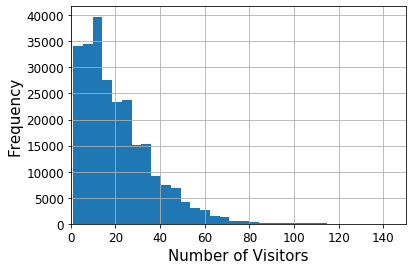

In [0]:
train['visitors'].hist(bins=200, xlabelsize=12, ylabelsize=12)
plt.xlabel("Number of Visitors", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,150])

skeeeewed

## Using weather data

In [0]:
weather_data_dir = '/content/drive/Shared drives/Predictive Competition/rrv-weather-data/'

def add_weather(dataset):
    print('Adding weather...')
    air_nearest = pd.read_csv(weather_data_dir + 'air_store_info_with_nearest_active_station.csv')
 #   hpg_nearest = pd.read_csv('rrv-weather-data/hpg_store_info_with_nearest_active_station.csv')
 #   hpg_nearest = pd.merge(hpg_nearest, store_relation, on='hpg_store_id', how='left')
 #   hpg_nearest = hpg_nearest[~hpg_nearest['air_store_id'].isnull()].drop('hpg_store_id',axis = 1)
 #   hpg_nearest  = hpg_nearest.rename(columns = {'hpg_area_name': 'air_area_name','hpg_genre_name':'air_genre_name'})
 #   air_nearest = pd.concat([air_nearest, hpg_nearest],axis = 0)
    
    unique_air_store_ids = list(dataset['air_store_id'].unique())
    
    weather_dir = weather_data_dir+'1-1-16_5-31-17_Weather/1-1-16_5-31-17_Weather/'
    weather_keep_columns = ['precipitation', 'avg_temperature']

    dataset_with_weather = dataset.copy()
    for column in weather_keep_columns:
        dataset_with_weather[column] = np.nan

    for air_id in unique_air_store_ids:
        station = air_nearest[air_nearest['air_store_id'] == air_id]['station_id'].iloc[0]
        weather_data = pd.read_csv(weather_dir + station + '.csv',
                                   parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})
        this_store = dataset['air_store_id'] == air_id
        merged = dataset[this_store].merge(weather_data, on='visit_date', how='left')

        for column in weather_keep_columns:
            dataset_with_weather.loc[this_store, column] = merged[column]
    print('Done')
    return dataset_with_weather


In [0]:
df_train2 = add_weather(train)

In [0]:
df_train2.isnull().sum()

air_store_id             0
visit_date               0
visitors                 0
dow                      0
year                     0
month                    0
day                      0
reserve_visitors         0
days_diff                0
air_genre_name           0
air_area_name            0
latitude                 0
longitude                0
day_of_week              0
holiday_flg              0
off_work                 0
precipitation       251904
avg_temperature     251717
dtype: int64

bluh